## Image Recognition: caltech101 | Angel Alvarez

In [104]:
# project uses the caltech101 dataset found here https://data.caltech.edu/records/mzrjq-6wc02

%pip install tensorflow
%pip install keras
%pip install matplotlib
%pip install tensorflow_datasets
%pip install numpy
%pip install seaborn
%pip install scikit-learn

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Le'ts inspect the data

In [105]:
train_data, val_data, test_data = tfds.load('caltech101', split=['train[:80%]', 'train[80%:]', 'test'], shuffle_files=True, as_supervised=True)

print(f"Training set size: {len(list(train_data))}")
print(f"Validation set size: {len(list(val_data))}")
print(f"Test set size: {len(list(test_data))}")

for image, label in train_data.take(1):
    print(f"Image shape: {image.shape}")
    print(f"Label: {label.numpy()}")

info = tfds.builder('caltech101').info
class_names = info.features['label'].names
print(f"Total classes: {len(class_names)}")



Training set size: 2448
Validation set size: 612
Test set size: 6084
Image shape: (297, 300, 3)
Label: 10
Total classes: 102


### print some image samples

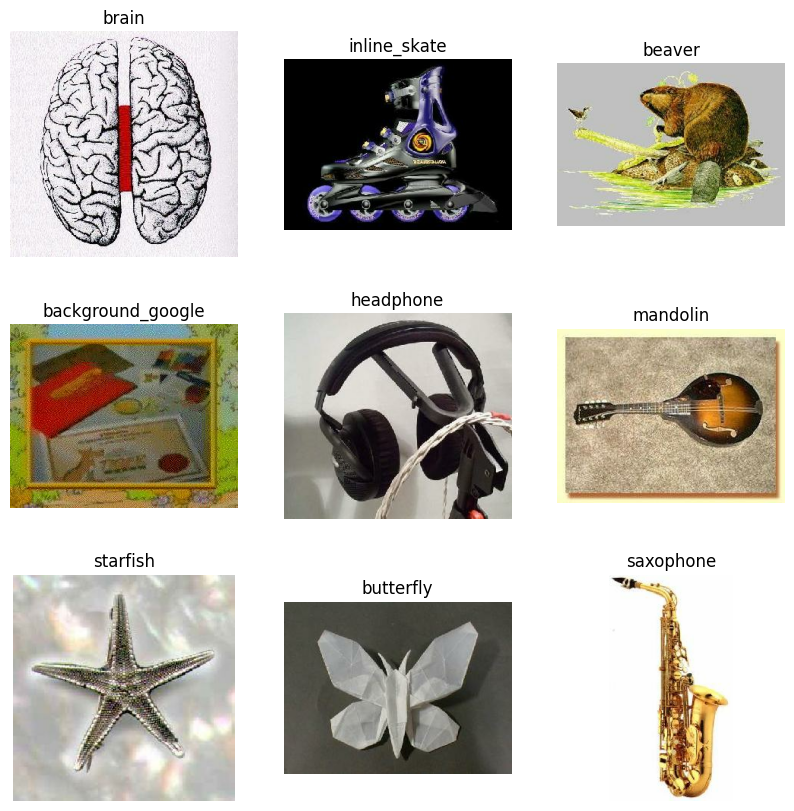

In [106]:
fig = plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_data.take(9)):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(image.numpy())
    ax.set_title(class_names[label.numpy()])
    ax.axis('off')
plt.show()

### let's see how many data points do we have per class

In [107]:

import collections
label_counts = collections.Counter([label.numpy() for _, label in train_data])
print(label_counts)


Counter({54: 29, 46: 28, 16: 28, 47: 27, 40: 27, 52: 27, 58: 27, 72: 27, 98: 27, 96: 27, 55: 27, 29: 27, 27: 27, 100: 27, 21: 27, 94: 26, 43: 26, 15: 26, 74: 26, 59: 26, 30: 26, 84: 26, 75: 26, 20: 26, 0: 26, 51: 25, 7: 25, 45: 25, 97: 25, 36: 25, 73: 25, 17: 25, 44: 25, 65: 25, 81: 25, 31: 25, 77: 25, 89: 25, 83: 25, 4: 24, 13: 24, 70: 24, 8: 24, 92: 24, 23: 24, 25: 24, 39: 24, 50: 24, 12: 24, 9: 24, 28: 24, 91: 24, 53: 24, 3: 24, 68: 24, 69: 24, 95: 24, 85: 24, 71: 24, 22: 24, 41: 24, 33: 24, 6: 24, 24: 24, 10: 23, 88: 23, 78: 23, 67: 23, 19: 23, 101: 23, 35: 23, 93: 23, 90: 23, 80: 23, 38: 23, 2: 23, 63: 23, 32: 23, 34: 23, 61: 22, 87: 22, 79: 22, 26: 22, 56: 22, 48: 22, 42: 22, 5: 22, 14: 22, 11: 22, 66: 22, 99: 21, 60: 21, 1: 21, 64: 21, 18: 21, 37: 21, 76: 20, 82: 20, 86: 20, 57: 19, 62: 19, 49: 18})


### getting our class names

In [108]:
# Print all label names
print("Class Names:")
for i, class_name in enumerate(class_names):
    print(f"{i}: {class_name}")

Class Names:
0: accordion
1: airplanes
2: anchor
3: ant
4: background_google
5: barrel
6: bass
7: beaver
8: binocular
9: bonsai
10: brain
11: brontosaurus
12: buddha
13: butterfly
14: camera
15: cannon
16: car_side
17: ceiling_fan
18: cellphone
19: chair
20: chandelier
21: cougar_body
22: cougar_face
23: crab
24: crayfish
25: crocodile
26: crocodile_head
27: cup
28: dalmatian
29: dollar_bill
30: dolphin
31: dragonfly
32: electric_guitar
33: elephant
34: emu
35: euphonium
36: ewer
37: faces
38: faces_easy
39: ferry
40: flamingo
41: flamingo_head
42: garfield
43: gerenuk
44: gramophone
45: grand_piano
46: hawksbill
47: headphone
48: hedgehog
49: helicopter
50: ibis
51: inline_skate
52: joshua_tree
53: kangaroo
54: ketch
55: lamp
56: laptop
57: leopards
58: llama
59: lobster
60: lotus
61: mandolin
62: mayfly
63: menorah
64: metronome
65: minaret
66: motorbikes
67: nautilus
68: octopus
69: okapi
70: pagoda
71: panda
72: pigeon
73: pizza
74: platypus
75: pyramid
76: revolver
77: rhino
78: r

### background_google seems to be a garbage class since it contains a lot of images that are just random and not related, let's exclude it from the datasets

Training set size after filtering: 2424
Validation set size after filtering: 606
Test set size after filtering: 5647


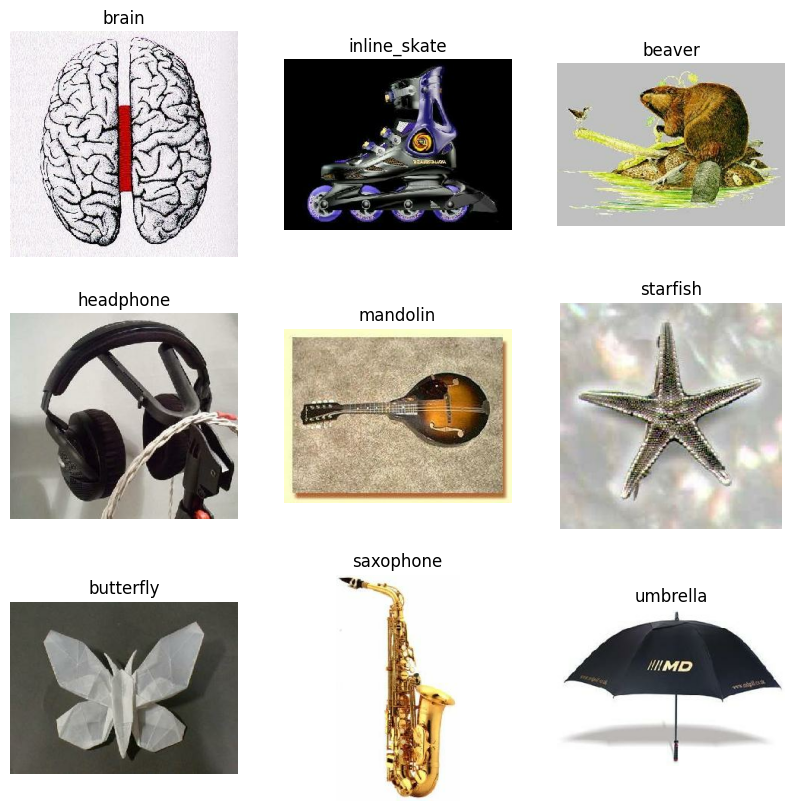

In [109]:
# get class names and find the index of "background_google" class
info = tfds.builder('caltech101').info
class_names = info.features['label'].names
google_background_index = class_names.index("background_google")

# remove "background_google" from the class names list
class_names = [name for name in class_names if name != "background_google"]

def filter_google_background(image, label):
    return tf.not_equal(label, google_background_index)

# filter the garbage class
train_data = train_data.filter(filter_google_background)
val_data = val_data.filter(filter_google_background)
test_data = test_data.filter(filter_google_background)

# adjust labels to account for the removal of "background_google"
def adjust_labels(image, label):
    return image, tf.where(label > google_background_index, label - 1, label)

train_data = train_data.map(adjust_labels)
val_data = val_data.map(adjust_labels)
test_data = test_data.map(adjust_labels)

print(f"Training set size after filtering: {len(list(train_data))}")
print(f"Validation set size after filtering: {len(list(val_data))}")
print(f"Test set size after filtering: {len(list(test_data))}")

fig = plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_data.take(9)):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(image.numpy())
    ax.set_title(class_names[label.numpy()])
    ax.axis('off')
plt.show()

### background_google should be gone, all the classes and labels were also adjusted properly

In [110]:
# Print all label names
print("Class Names:")
for i, class_name in enumerate(class_names):
    print(f"{i}: {class_name}")

Class Names:
0: accordion
1: airplanes
2: anchor
3: ant
4: barrel
5: bass
6: beaver
7: binocular
8: bonsai
9: brain
10: brontosaurus
11: buddha
12: butterfly
13: camera
14: cannon
15: car_side
16: ceiling_fan
17: cellphone
18: chair
19: chandelier
20: cougar_body
21: cougar_face
22: crab
23: crayfish
24: crocodile
25: crocodile_head
26: cup
27: dalmatian
28: dollar_bill
29: dolphin
30: dragonfly
31: electric_guitar
32: elephant
33: emu
34: euphonium
35: ewer
36: faces
37: faces_easy
38: ferry
39: flamingo
40: flamingo_head
41: garfield
42: gerenuk
43: gramophone
44: grand_piano
45: hawksbill
46: headphone
47: hedgehog
48: helicopter
49: ibis
50: inline_skate
51: joshua_tree
52: kangaroo
53: ketch
54: lamp
55: laptop
56: leopards
57: llama
58: lobster
59: lotus
60: mandolin
61: mayfly
62: menorah
63: metronome
64: minaret
65: motorbikes
66: nautilus
67: octopus
68: okapi
69: pagoda
70: panda
71: pigeon
72: pizza
73: platypus
74: pyramid
75: revolver
76: rhino
77: rooster
78: saxophone
7

### normalize the data and generate new augmented data from the original training set 

In [111]:
import cv2

def resize_image(image, label):
    image = tf.image.resize(image, [128, 128])
    return image, label

train_data = train_data.map(resize_image)
val_data = val_data.map(resize_image)
test_data = test_data.map(resize_image)

def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_data = train_data.map(normalize_image)
val_data = val_data.map(normalize_image)
test_data = test_data.map(normalize_image)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomContrast(0.3),
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomTranslation(0.15, 0.15)
])

def augment_image(image, label):
    image = data_augmentation(image)
    return image, label

def generate_augmented_data(train_data, number_of_augments):
    augmented_datasets = [train_data]  # original data

    for _ in range(number_of_augments):
        augmented_data = train_data.map(augment_image)
        augmented_datasets.append(augmented_data)

    # add new data to original dsta
    full_train_data = augmented_datasets[0]
    for aug_data in augmented_datasets[1:]:
        full_train_data = full_train_data.concatenate(aug_data)

    return full_train_data

train_data = generate_augmented_data(train_data, number_of_augments=2)
train_data_size = len(list(train_data))
train_data = train_data.shuffle(buffer_size=train_data_size)

# batch and prefetch data
train_data = train_data.batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
val_data = val_data.batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [112]:
for image, label in train_data.take(10):
    print(f"Image shape: {image.shape}")
    print(f"Label: {label.numpy()}")

Image shape: (32, 128, 128, 3)
Label: [99 27 72 79 58 63 56 14  2 89 87 52 62 50 16 88 51 28 12 61 83 62 27 71
 11 42 49 47 30  0 94 49]
Image shape: (32, 128, 128, 3)
Label: [98 95 92 88 13 56 91 16 46 31 65 31 58 33 61 13 34 31 56 30 31 28 58 43
 13 80 91 44  3  9 19  0]
Image shape: (32, 128, 128, 3)
Label: [ 90  63  23 100  10   5  19  57  40  79   4  65  93  21  15  91   6  98
  99  74  76  38  64  27  53  84   5  71  57  32  71   3]
Image shape: (32, 128, 128, 3)
Label: [  4  62   4  59  95  32  57  39  91  25  76  81  66  44  86 100  60  19
  83  66  28  99  43  88 100  18  94  67  52  67  95   5]
Image shape: (32, 128, 128, 3)
Label: [14 62 37 44 39 95 51 44 62 79 74 80 68 55 16 22 57 92 25 50 77 33 54 83
 67 78 20 64 86 95  1 11]
Image shape: (32, 128, 128, 3)
Label: [90 78 41 14 77 59  1 69 57 90 62 55 90 31 25 34 32 87 63 57 86 36 66 79
 69 76 52  8 64  7 16 89]
Image shape: (32, 128, 128, 3)
Label: [68 21 12  2  4  9  3 36  0 35 42 43 28 56 72 16 86 33  5 64 26 13 14 72
 64

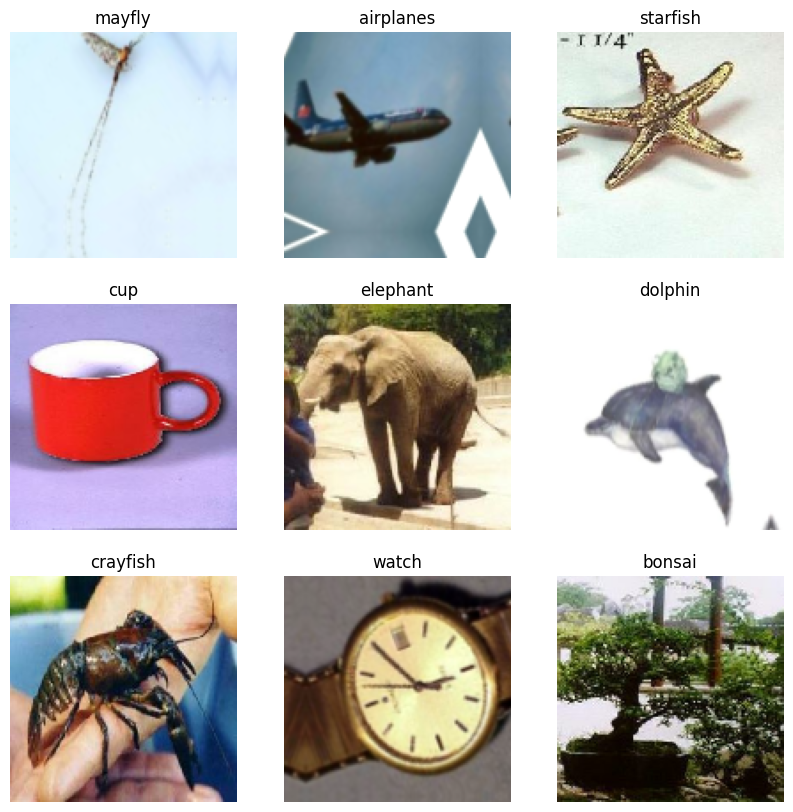

In [113]:
fig = plt.figure(figsize=(10, 10))
for i, (image_batch, label_batch) in enumerate(train_data.take(9)):
    image = image_batch[0].numpy().squeeze()
    label = label_batch[0].numpy()
    
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(image, cmap='gray')  
    ax.set_title(class_names[label])
    ax.axis('off')

plt.show()



### utility function to print some performance metrics for the models

In [114]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def print_results(model):
    # extract test images and labels from the test dataset
    test_images, test_labels = zip(*[(image, label) for image, label in tfds.as_numpy(test_data)])
    test_images = np.array([image for batch in test_images for image in batch])
    test_labels = np.array([label for batch in test_labels for label in batch])

    # generate predictions
    predictions = model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1)

    # accuracy
    accuracy = accuracy_score(test_labels, predicted_classes)
    print(f"accuracy: {accuracy * 100:.2f}%")

    # average scores
    avg_precision = precision_score(test_labels, predicted_classes, average='weighted')
    avg_recall = recall_score(test_labels, predicted_classes, average='weighted')
    avg_f1 = f1_score(test_labels, predicted_classes, average='weighted')
    print(f"\naverage precision: {avg_precision:.2f}")
    print(f"average recall: {avg_recall:.2f}")
    print(f"average F1 score: {avg_f1:.2f}")

    # full Classification Report
    print("\nclassification report:")
    print(classification_report(test_labels, predicted_classes, target_names=class_names[:101]))  # Ensure 101 target names

    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='lower right')
    plt.show()


In [115]:
def test_model(model, num_samples):
    # extract test images and labels
    test_images, test_labels = zip(*[(image, label) for image, label in tfds.as_numpy(test_data)])
    test_images = np.array([image for batch in test_images for image in batch])
    test_labels = np.array([label for batch in test_labels for label in batch])

    # predict the classes
    predictions = model.predict(test_images)

    # randomly select samples
    indices = np.random.choice(len(test_images), size=num_samples, replace=False)
    sample_images = test_images[indices]
    sample_labels = test_labels[indices]
    sample_predictions = predictions[indices]
    predicted_sample_classes = np.argmax(sample_predictions, axis=1)

    cols = 5  # number of images per row
    rows = (num_samples + cols - 1) // cols 

    fig = plt.figure(figsize=(15, rows * 3))  # adjust height based on rows
    for i in range(num_samples):
        ax = fig.add_subplot(rows, cols, i + 1)
        image = sample_images[i].squeeze()
        ax.imshow(image, cmap='gray')  
        actual_label = class_names[sample_labels[i]]
        predicted_label = class_names[predicted_sample_classes[i]]
        ax.set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}", fontsize=10)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


### ensure that the model doesn't run out of data while training


In [41]:
# train_data = train_data.repeat()
# val_data = val_data.repeat()

# batch_size = 32

# train_data_size = tf.data.experimental.cardinality(train_data).numpy()
# steps_per_epoch = train_data_size // batch_size

### base or default model

Epoch 1/10


/opt/miniconda3/envs/ml/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    227/Unknown 33s 109ms/step - accuracy: 0.0236 - loss: 4.5539

/opt/miniconda3/envs/ml/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


227/227 ━━━━━━━━━━━━━━━━━━━━ 34s 112ms/step - accuracy: 0.0237 - loss: 4.5532 - val_accuracy: 0.0806 - val_loss: 3.9609
Epoch 2/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 33s 113ms/step - accuracy: 0.1402 - loss: 3.8347 - val_accuracy: 0.2188 - val_loss: 3.4155
Epoch 3/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 33s 112ms/step - accuracy: 0.2700 - loss: 3.1733 - val_accuracy: 0.2730 - val_loss: 3.0675
Epoch 4/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 35s 118ms/step - accuracy: 0.3549 - loss: 2.6919 - val_accuracy: 0.3109 - val_loss: 2.8996
Epoch 5/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 34s 116ms/step - accuracy: 0.4525 - loss: 2.2358 - val_accuracy: 0.3355 - val_loss: 2.8182
Epoch 6/10


2024-11-26 17:06:32.095356: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


227/227 ━━━━━━━━━━━━━━━━━━━━ 34s 115ms/step - accuracy: 0.5308 - loss: 1.9074 - val_accuracy: 0.3487 - val_loss: 2.9376
Epoch 7/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 34s 114ms/step - accuracy: 0.5600 - loss: 1.7834 - val_accuracy: 0.3766 - val_loss: 2.8016
Epoch 8/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 33s 113ms/step - accuracy: 0.6197 - loss: 1.5461 - val_accuracy: 0.3651 - val_loss: 2.9005
Epoch 9/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 34s 115ms/step - accuracy: 0.6343 - loss: 1.4493 - val_accuracy: 0.3734 - val_loss: 2.9089
Epoch 10/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 33s 114ms/step - accuracy: 0.6603 - loss: 1.3456 - val_accuracy: 0.3865 - val_loss: 2.9288
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step
accuracy: 55.24%

average precision: 0.67
average recall: 0.55
average F1 score: 0.58

classification report:
                 precision    recall  f1-score   support

      accordion       0.27      0.60      0.38        25
      airplanes       0.98      0.65      0.78       769
         anchor       0.07     

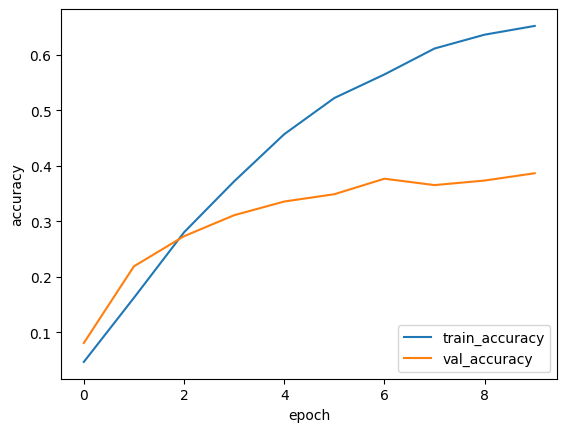

In [42]:

def create_model1():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])
    return model

model1 = create_model1()
model1.compile(    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model1.fit(train_data, epochs=10, validation_data=val_data)

print_results(model1)


176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step


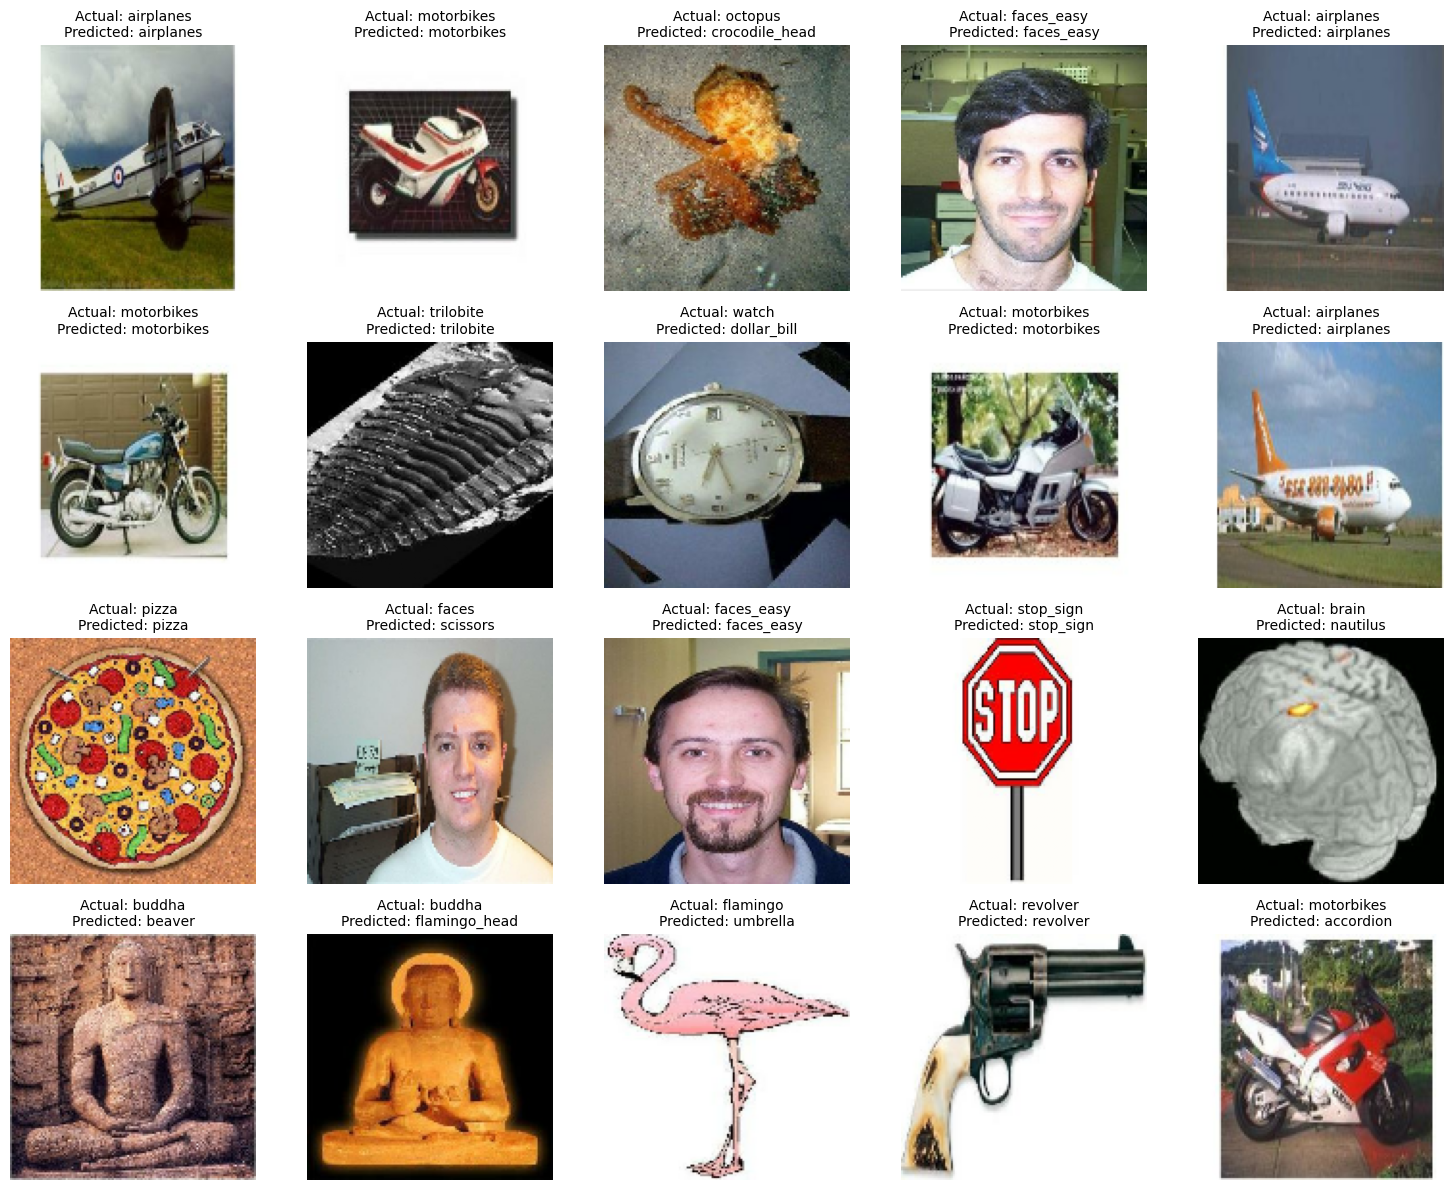

In [43]:
test_model(model1, 20)


In [55]:
model1.save_weights('models/model1.weights.h5')

### we are noticing some overfitting, introduce small dropout before the output layer

Epoch 1/10


/opt/miniconda3/envs/ml/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    227/Unknown 34s 112ms/step - accuracy: 0.0230 - loss: 4.5810

/opt/miniconda3/envs/ml/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


227/227 ━━━━━━━━━━━━━━━━━━━━ 35s 115ms/step - accuracy: 0.0231 - loss: 4.5805 - val_accuracy: 0.0789 - val_loss: 4.0079
Epoch 2/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 36s 122ms/step - accuracy: 0.1051 - loss: 4.0388 - val_accuracy: 0.1628 - val_loss: 3.6010
Epoch 3/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 36s 122ms/step - accuracy: 0.1825 - loss: 3.5513 - val_accuracy: 0.2122 - val_loss: 3.3347
Epoch 4/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 35s 119ms/step - accuracy: 0.2552 - loss: 3.1642 - val_accuracy: 0.2549 - val_loss: 3.0796
Epoch 5/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 37s 126ms/step - accuracy: 0.3176 - loss: 2.8490 - val_accuracy: 0.2747 - val_loss: 3.0463
Epoch 6/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 35s 119ms/step - accuracy: 0.3655 - loss: 2.5617 - val_accuracy: 0.3289 - val_loss: 2.8375
Epoch 7/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 36s 123ms/step - accuracy: 0.4261 - loss: 2.3247 - val_accuracy: 0.3684 - val_loss: 2.7308
Epoch 8/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 44s 159ms/step - accuracy: 0.4445 - loss: 2.2301 - val

/opt/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/minic

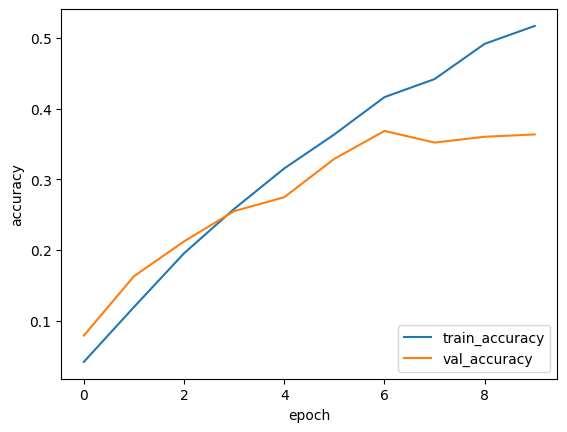

In [44]:

# model with dropout 0.2
def create_model2():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])
    return model

model2 = create_model2()
# larger learning rate
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model2.fit(train_data, epochs=10, validation_data=val_data)

print_results(model2)


In [56]:
model2.save_weights('models/model2.weights.h5')

### overfitting seems to be fixed thanks to the dropout layer, increase the number of epochs to see if the accuracy keeps increasing

### let's now come up with a more complex network to see if that also helps further increase the accuracy of the model, let's add an extra dense layer and also more dropout layers 

/opt/miniconda3/envs/ml/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
    227/Unknown 60s 215ms/step - accuracy: 0.0531 - loss: 4.8140

/opt/miniconda3/envs/ml/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 219ms/step - accuracy: 0.0532 - loss: 4.8123 - val_accuracy: 0.0099 - val_loss: 7.6049
Epoch 2/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 217ms/step - accuracy: 0.1740 - loss: 3.7387 - val_accuracy: 0.0411 - val_loss: 4.6304
Epoch 3/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 200ms/step - accuracy: 0.2819 - loss: 3.1353 - val_accuracy: 0.2368 - val_loss: 3.0951
Epoch 4/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 200ms/step - accuracy: 0.3605 - loss: 2.6752 - val_accuracy: 0.3306 - val_loss: 2.7378
Epoch 5/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 209ms/step - accuracy: 0.4387 - loss: 2.3431 - val_accuracy: 0.3947 - val_loss: 2.3617
Epoch 6/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 215ms/step - accuracy: 0.4998 - loss: 2.0307 - val_accuracy: 0.4161 - val_loss: 2.2117
Epoch 7/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 59s 224ms/step - accuracy: 0.5482 - loss: 1.8139 - val_accuracy: 0.4342 - val_loss: 2.3224
Epoch 8/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 215ms/step - accuracy: 0.5951 - loss: 1.6126 - val

2024-11-26 17:31:18.923121: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 201ms/step - accuracy: 0.7598 - loss: 0.9041 - val_accuracy: 0.5164 - val_loss: 1.8379
Epoch 17/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 199ms/step - accuracy: 0.7725 - loss: 0.8638 - val_accuracy: 0.5296 - val_loss: 1.7963
Epoch 18/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 201ms/step - accuracy: 0.7806 - loss: 0.8252 - val_accuracy: 0.5016 - val_loss: 1.9467
Epoch 19/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 201ms/step - accuracy: 0.7932 - loss: 0.7849 - val_accuracy: 0.4852 - val_loss: 2.0260
Epoch 20/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 201ms/step - accuracy: 0.7867 - loss: 0.7816 - val_accuracy: 0.5197 - val_loss: 1.9495
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step
accuracy: 66.69%

average precision: 0.75
average recall: 0.67
average F1 score: 0.69

classification report:
                 precision    recall  f1-score   support

      accordion       0.63      0.48      0.55        25
      airplanes       0.98      0.84      0.90       769
         anchor       0.25  

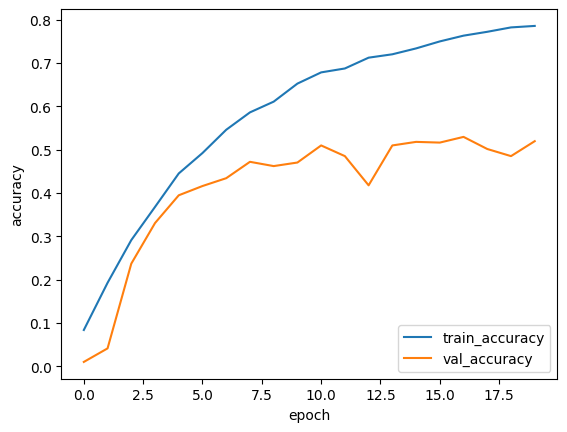

In [45]:
def create_model3():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),  
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),  
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),  # higher dropout to regularize

        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])
    return model

model3 = create_model3()
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model3.fit(train_data, epochs=20, validation_data=val_data)

print_results(model3)


In [57]:
model3.save_weights('models/model3.weights.h5')

### seems like we're going in the right direction, let's now implement a dynamic learning rate

/opt/miniconda3/envs/ml/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/35
    227/Unknown 70s 254ms/step - accuracy: 0.0338 - loss: 5.2186

/opt/miniconda3/envs/ml/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


227/227 ━━━━━━━━━━━━━━━━━━━━ 71s 259ms/step - accuracy: 0.0339 - loss: 5.2168 - val_accuracy: 0.0115 - val_loss: 6.2998
Epoch 2/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 209ms/step - accuracy: 0.1193 - loss: 4.0994 - val_accuracy: 0.0329 - val_loss: 5.1254
Epoch 3/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 210ms/step - accuracy: 0.2025 - loss: 3.4831 - val_accuracy: 0.2204 - val_loss: 3.2476
Epoch 4/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 211ms/step - accuracy: 0.2661 - loss: 3.1074 - val_accuracy: 0.2484 - val_loss: 3.1343
Epoch 5/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 209ms/step - accuracy: 0.3254 - loss: 2.7867 - val_accuracy: 0.3059 - val_loss: 2.8543
Epoch 6/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 59s 225ms/step - accuracy: 0.3836 - loss: 2.4803 - val_accuracy: 0.2878 - val_loss: 2.8030
Epoch 7/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 217ms/step - accuracy: 0.4349 - loss: 2.2629 - val_accuracy: 0.3586 - val_loss: 2.4820
Epoch 8/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 220ms/step - accuracy: 0.4798 - loss: 2.0717 - val

2024-11-26 19:09:39.733553: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


227/227 ━━━━━━━━━━━━━━━━━━━━ 59s 226ms/step - accuracy: 0.7775 - loss: 0.8044 - val_accuracy: 0.5230 - val_loss: 1.9220
Epoch 26/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - accuracy: 0.7681 - loss: 0.8454 - val_accuracy: 0.5411 - val_loss: 1.7402
Epoch 27/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 212ms/step - accuracy: 0.7671 - loss: 0.8436 - val_accuracy: 0.5543 - val_loss: 1.7375
Epoch 28/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 210ms/step - accuracy: 0.7813 - loss: 0.7862 - val_accuracy: 0.5641 - val_loss: 1.6520
Epoch 29/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - accuracy: 0.7844 - loss: 0.7708 - val_accuracy: 0.5543 - val_loss: 1.8619
Epoch 30/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - accuracy: 0.7984 - loss: 0.7165 - val_accuracy: 0.5526 - val_loss: 1.7972
Epoch 31/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 89s 351ms/step - accuracy: 0.7959 - loss: 0.7568 - val_accuracy: 0.5724 - val_loss: 1.6560
Epoch 32/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 64s 243ms/step - accuracy: 0.7926 - loss: 0.733

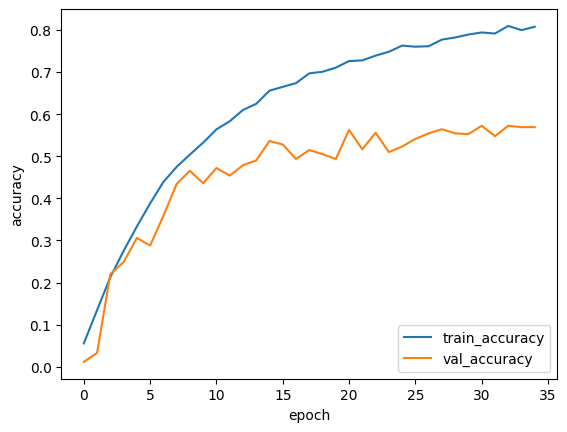

In [47]:
# this is the same as the model right above but with a changing learning rate
def create_model4():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3), 

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3), 

        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),  
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3), 

        tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),  
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'), 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),  

        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])
    return model

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=5000,
    decay_rate=0.95)

model4 = create_model4()
model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model4.fit(train_data, epochs=35, validation_data=val_data)

print_results(model4)


In [58]:
model4.save_weights('models/model4.weights.h5')

### let's double the units of every layer

Epoch 1/35


/opt/miniconda3/envs/ml/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    227/Unknown 151s 619ms/step - accuracy: 0.0351 - loss: 5.2173

/opt/miniconda3/envs/ml/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


227/227 ━━━━━━━━━━━━━━━━━━━━ 154s 631ms/step - accuracy: 0.0352 - loss: 5.2157 - val_accuracy: 0.0132 - val_loss: 5.9970
Epoch 2/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 154s 641ms/step - accuracy: 0.1205 - loss: 4.1439 - val_accuracy: 0.0592 - val_loss: 4.7177
Epoch 3/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 153s 638ms/step - accuracy: 0.2219 - loss: 3.4343 - val_accuracy: 0.2056 - val_loss: 3.5787
Epoch 4/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 153s 638ms/step - accuracy: 0.3044 - loss: 2.8947 - val_accuracy: 0.3487 - val_loss: 2.6870
Epoch 5/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 160s 669ms/step - accuracy: 0.3785 - loss: 2.4827 - val_accuracy: 0.3914 - val_loss: 2.4291
Epoch 6/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 167s 696ms/step - accuracy: 0.4834 - loss: 2.0473 - val_accuracy: 0.4474 - val_loss: 2.2125
Epoch 7/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 169s 709ms/step - accuracy: 0.5354 - loss: 1.7873 - val_accuracy: 0.4441 - val_loss: 2.2293
Epoch 8/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 173s 727ms/step - accuracy: 0.5636 - loss: 1.64

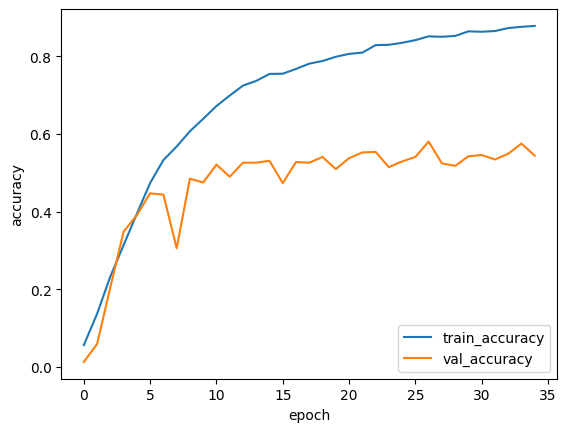

In [48]:
def create_model5():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3), 

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3), 

        tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),  
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3), 

        tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'),  
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'), 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),  

        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])
    return model

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=5000,
    decay_rate=0.95)

model5 = create_model5()
model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model5.fit(train_data, epochs=35, validation_data=val_data)

print_results(model5)


In [59]:
model5.save_weights('models/model5.weights.h5')

### Let's have a higher dropout rate, let's also halve the units of every layer


Epoch 1/35


/opt/miniconda3/envs/ml/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    227/Unknown 63s 229ms/step - accuracy: 0.0241 - loss: 5.3638

/opt/miniconda3/envs/ml/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


227/227 ━━━━━━━━━━━━━━━━━━━━ 64s 233ms/step - accuracy: 0.0241 - loss: 5.3623 - val_accuracy: 0.0082 - val_loss: 6.6758
Epoch 2/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 215ms/step - accuracy: 0.0724 - loss: 4.4736 - val_accuracy: 0.0181 - val_loss: 6.4265
Epoch 3/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 67s 260ms/step - accuracy: 0.1159 - loss: 4.0088 - val_accuracy: 0.0132 - val_loss: 5.8756
Epoch 4/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 70s 275ms/step - accuracy: 0.1635 - loss: 3.6724 - val_accuracy: 0.0641 - val_loss: 4.7431
Epoch 5/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 222ms/step - accuracy: 0.1936 - loss: 3.4181 - val_accuracy: 0.0510 - val_loss: 4.7963
Epoch 6/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 65s 253ms/step - accuracy: 0.2499 - loss: 3.1586 - val_accuracy: 0.0510 - val_loss: 5.1027
Epoch 7/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 227ms/step - accuracy: 0.2752 - loss: 2.9968 - val_accuracy: 0.0724 - val_loss: 4.4168
Epoch 8/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 59s 224ms/step - accuracy: 0.3003 - loss: 2.8704 - val

/opt/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/minic

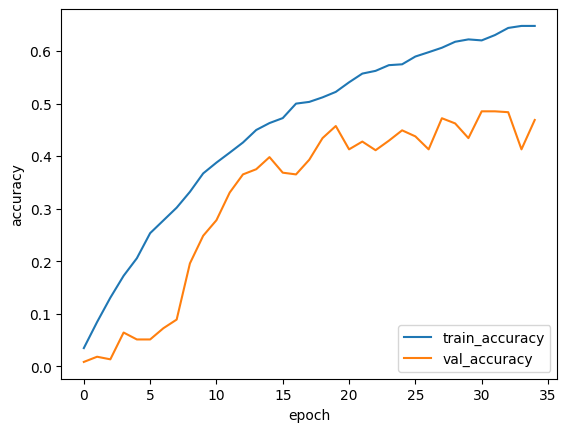

In [49]:
def create_model6():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.5), 

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.5), 

        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),  
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.5), 

        tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),  
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'), 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),  

        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])
    return model

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=5000,
    decay_rate=0.95)

model6 = create_model6()
model6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model6.fit(train_data, epochs=35, validation_data=val_data)

print_results(model6)


In [60]:
model6.save_weights('models/model6.weights.h5')

### seems like that didn't help...

### let's finally test with a static learning rate but more epochs

Epoch 1/50


/opt/miniconda3/envs/ml/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    227/Unknown 55s 198ms/step - accuracy: 0.0467 - loss: 4.9878

/opt/miniconda3/envs/ml/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 202ms/step - accuracy: 0.0469 - loss: 4.9862 - val_accuracy: 0.0181 - val_loss: 6.2018
Epoch 2/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 209ms/step - accuracy: 0.1569 - loss: 3.8545 - val_accuracy: 0.0822 - val_loss: 4.5019
Epoch 3/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 203ms/step - accuracy: 0.2396 - loss: 3.3189 - val_accuracy: 0.2401 - val_loss: 3.1979
Epoch 4/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 193ms/step - accuracy: 0.3278 - loss: 2.8583 - val_accuracy: 0.2944 - val_loss: 3.0010
Epoch 5/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 51s 193ms/step - accuracy: 0.3930 - loss: 2.5144 - val_accuracy: 0.3701 - val_loss: 2.5422
Epoch 6/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 51s 191ms/step - accuracy: 0.4619 - loss: 2.1913 - val_accuracy: 0.3503 - val_loss: 2.7512
Epoch 7/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 196ms/step - accuracy: 0.5140 - loss: 1.9921 - val_accuracy: 0.4161 - val_loss: 2.3540
Epoch 8/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 202ms/step - accuracy: 0.5359 - loss: 1.8498 - val

2024-11-26 22:09:42.253716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:274: Filling up shuffle buffer (this may take a while): 6854 of 7272
2024-11-26 22:09:44.118170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


227/227 ━━━━━━━━━━━━━━━━━━━━ 76s 275ms/step - accuracy: 0.8692 - loss: 0.4563 - val_accuracy: 0.5526 - val_loss: 1.9133
Epoch 45/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 205ms/step - accuracy: 0.8715 - loss: 0.4585 - val_accuracy: 0.5592 - val_loss: 1.8900
Epoch 46/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.8762 - loss: 0.4376

2024-11-26 22:12:34.742295: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 198ms/step - accuracy: 0.8762 - loss: 0.4377 - val_accuracy: 0.5559 - val_loss: 1.8550
Epoch 47/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 198ms/step - accuracy: 0.8724 - loss: 0.4392 - val_accuracy: 0.5822 - val_loss: 1.7881
Epoch 48/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 197ms/step - accuracy: 0.8700 - loss: 0.4370 - val_accuracy: 0.5247 - val_loss: 1.9088
Epoch 49/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 203ms/step - accuracy: 0.8767 - loss: 0.4358 - val_accuracy: 0.5576 - val_loss: 1.7531
Epoch 50/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 205ms/step - accuracy: 0.8988 - loss: 0.3625 - val_accuracy: 0.5641 - val_loss: 1.7890
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step
accuracy: 69.89%

average precision: 0.77
average recall: 0.70
average F1 score: 0.72

classification report:
                 precision    recall  f1-score   support

      accordion       0.56      0.72      0.63        25
      airplanes       0.99      0.84      0.91       769
         anchor       0.38  

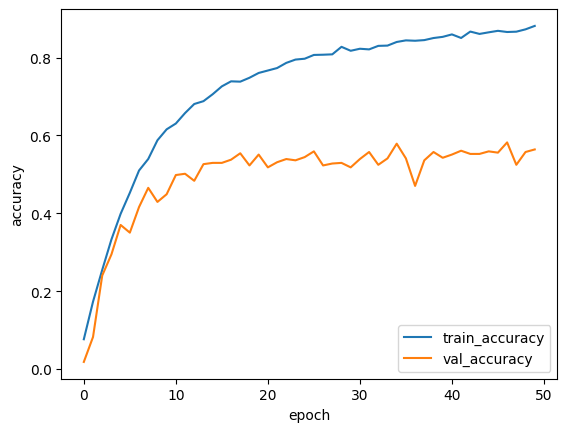

In [50]:
def create_model7():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),  
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),  
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])
    return model

model7 = create_model7()
model7.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model7.fit(train_data, epochs=50, validation_data=val_data)

print_results(model7)


In [61]:
model7.save_weights('models/model7.weights.h5')

### Model4 has had the best performance so far, with an accuracy of about 70% on the testing dataset; however, it seems like we are seeing diminishing returns after about 65% accuracy, let's try to use transfer learning to see if that can help

### Transfer Learning

Epoch 1/10
    227/Unknown 26s 65ms/step - accuracy: 0.2555 - loss: 3.5396

/opt/miniconda3/envs/ml/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


227/227 ━━━━━━━━━━━━━━━━━━━━ 28s 74ms/step - accuracy: 0.2564 - loss: 3.5348 - val_accuracy: 0.7516 - val_loss: 0.8206
Epoch 2/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 24s 68ms/step - accuracy: 0.7706 - loss: 0.8835 - val_accuracy: 0.7796 - val_loss: 0.6235
Epoch 3/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 23s 69ms/step - accuracy: 0.8421 - loss: 0.5664 - val_accuracy: 0.7878 - val_loss: 0.6002
Epoch 4/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - accuracy: 0.8852 - loss: 0.4209 - val_accuracy: 0.8076 - val_loss: 0.5407
Epoch 5/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 24s 70ms/step - accuracy: 0.8972 - loss: 0.3646 - val_accuracy: 0.8207 - val_loss: 0.5091
Epoch 6/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 23s 67ms/step - accuracy: 0.9166 - loss: 0.2899 - val_accuracy: 0.8092 - val_loss: 0.5094
Epoch 7/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 23s 67ms/step - accuracy: 0.9114 - loss: 0.2869 - val_accuracy: 0.8076 - val_loss: 0.5625
Epoch 8/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 24s 72ms/step - accuracy: 0.9257 - loss: 0.2521 - val_accurac

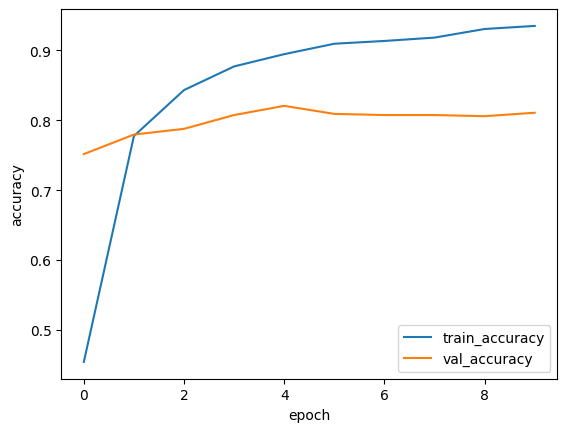

In [116]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential, Model

# load the pre-trained MobileNetV2 model
base_model9 = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model9.trainable = False  # freeze base model

# build the transfer learning model
model9 = Sequential([
    base_model9,  # pre-trained base
    GlobalAveragePooling2D(),  
    Dense(128, activation='relu'),
    Dropout(0.2),  # regularization to prevent overfitting
    Dense(len(class_names), activation='softmax')  # output layer
])

model9.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model9.fit(train_data, epochs=10, validation_data=val_data)

print_results(model9)


In [118]:
model9.save_weights('models/model9.weights.h5')

### we increased the best accuracy by 19% by using transfer learning, going from 70% to 89% with just a few layers after the pre-trained base model, let's try combining our best performing model with the pre-trained model to see if that further improves the accuracy

Epoch 1/10
    227/Unknown 26s 66ms/step - accuracy: 0.1861 - loss: 3.8839

/opt/miniconda3/envs/ml/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


227/227 ━━━━━━━━━━━━━━━━━━━━ 29s 76ms/step - accuracy: 0.1868 - loss: 3.8794 - val_accuracy: 0.6891 - val_loss: 1.0264
Epoch 2/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 25s 75ms/step - accuracy: 0.6546 - loss: 1.3198 - val_accuracy: 0.7467 - val_loss: 0.7526
Epoch 3/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - accuracy: 0.7277 - loss: 0.9754 - val_accuracy: 0.7763 - val_loss: 0.6053
Epoch 4/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 24s 73ms/step - accuracy: 0.7794 - loss: 0.7889 - val_accuracy: 0.7928 - val_loss: 0.6316
Epoch 5/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 24s 72ms/step - accuracy: 0.8127 - loss: 0.6419 - val_accuracy: 0.7895 - val_loss: 0.6289
Epoch 6/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.8288 - loss: 0.6060 - val_accuracy: 0.7730 - val_loss: 0.5991
Epoch 7/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - accuracy: 0.8433 - loss: 0.5446 - val_accuracy: 0.7944 - val_loss: 0.6134
Epoch 8/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 25s 74ms/step - accuracy: 0.8603 - loss: 0.4936 - val_accurac

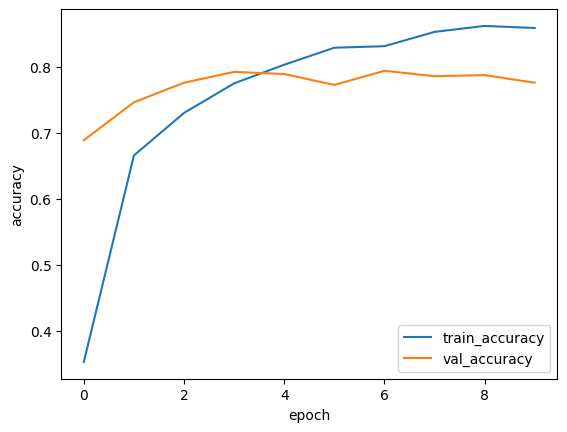

In [125]:
base_model10 = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model10.trainable = False  # freeze base model

model10 = Sequential([
    base_model10,  
    GlobalAveragePooling2D(),  

    Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    
    Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),  

    Dense(len(class_names), activation='softmax') 
])

# dynamic learning rate just like with model 4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=5000,
    decay_rate=0.95)

model10.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 10 epochs instead of 35 like in model 4
history = model10.fit(train_data, epochs=10, validation_data=val_data)

print_results(model10)

### seems like the accuracy did not improve after adding more layers to the transfer learning network

In [126]:
model10.save_weights('models/model10.weights.h5')

### let's compare our best model trained from scratch agains the transfer learning models

In [130]:
def test_models(model1, model2, num_samples):
    # extract test images and labels
    test_images, test_labels = zip(*[(image, label) for image, label in tfds.as_numpy(test_data)])
    test_images = np.array([image for batch in test_images for image in batch])
    test_labels = np.array([label for batch in test_labels for label in batch])

    # predict the classes
    predictions1 = model1.predict(test_images)
    predictions2 = model2.predict(test_images)

    # randomly select samples
    indices = np.random.choice(len(test_images), size=num_samples, replace=False)
    sample_images = test_images[indices]
    sample_labels = test_labels[indices]
    sample_predictions1 = predictions1[indices]
    sample_predictions2 = predictions2[indices]
    predicted_classes1 = np.argmax(sample_predictions1, axis=1)
    predicted_classes2 = np.argmax(sample_predictions2, axis=1)

    cols = 5  
    rows = (num_samples + cols - 1) // cols 

    fig1 = plt.figure(figsize=(15, rows * 3))  
    for i in range(num_samples):
        ax = fig1.add_subplot(rows, cols, i + 1)
        image = sample_images[i].squeeze()
        ax.imshow(image, cmap='gray')  
        actual_label = class_names[sample_labels[i]]
        predicted_label = class_names[predicted_classes1[i]]
        ax.set_title(f"Model 1\nActual: {actual_label}\nPredicted: {predicted_label}", fontsize=10)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    fig2 = plt.figure(figsize=(15, rows * 3))  
    for i in range(num_samples):
        ax = fig2.add_subplot(rows, cols, i + 1)
        image = sample_images[i].squeeze()
        ax.imshow(image, cmap='gray')  
        actual_label = class_names[sample_labels[i]]
        predicted_label = class_names[predicted_classes2[i]]
        ax.set_title(f"Model 2\nActual: {actual_label}\nPredicted: {predicted_label}", fontsize=10)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [132]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential, Model

# load the pre-trained MobileNetV2 model
base_model9 = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model9.trainable = False  # freeze base model

from_scratch_model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3), 

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3), 

        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),  
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3), 

        tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),  
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'), 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),  

        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])

from_scratch_model.load_weights('models/model4.weights.h5')

pre_trained_model = Sequential([
    base_model9,  # pre-trained base
    GlobalAveragePooling2D(),  
    Dense(128, activation='relu'),
    Dropout(0.2),  # regularization to prevent overfitting
    Dense(len(class_names), activation='softmax')  # output layer
])

pre_trained_model.load_weights('models/model9.weights.h5')

/opt/miniconda3/envs/ml/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step


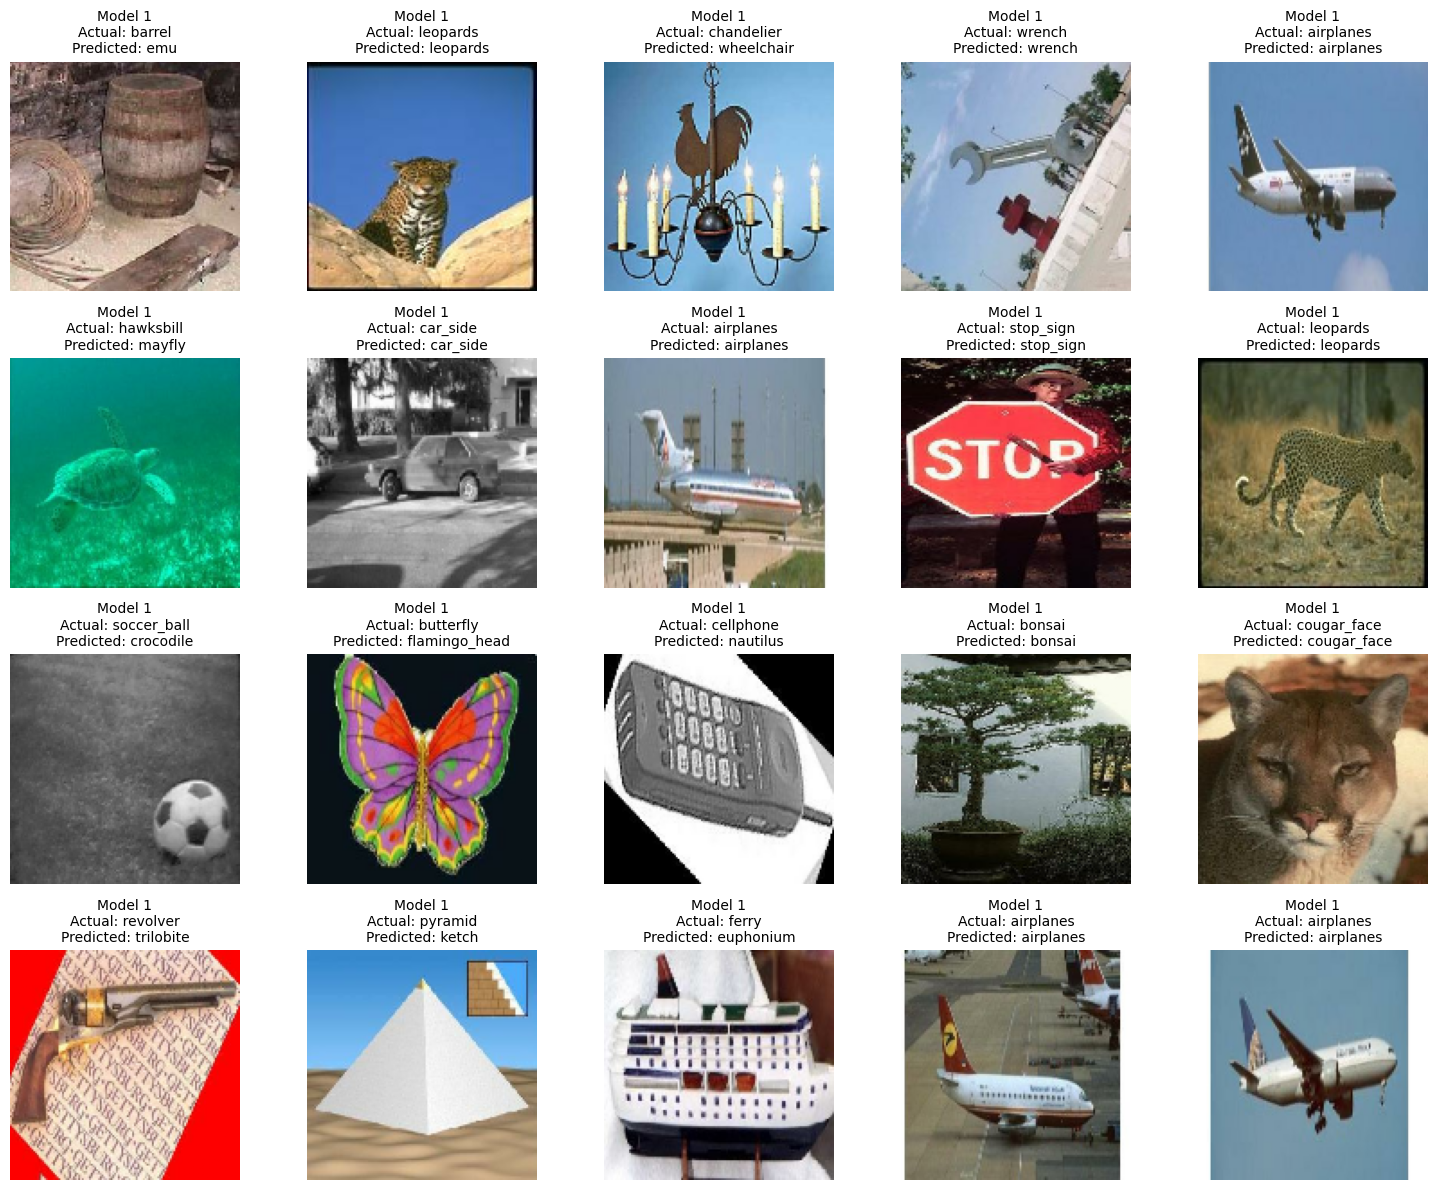

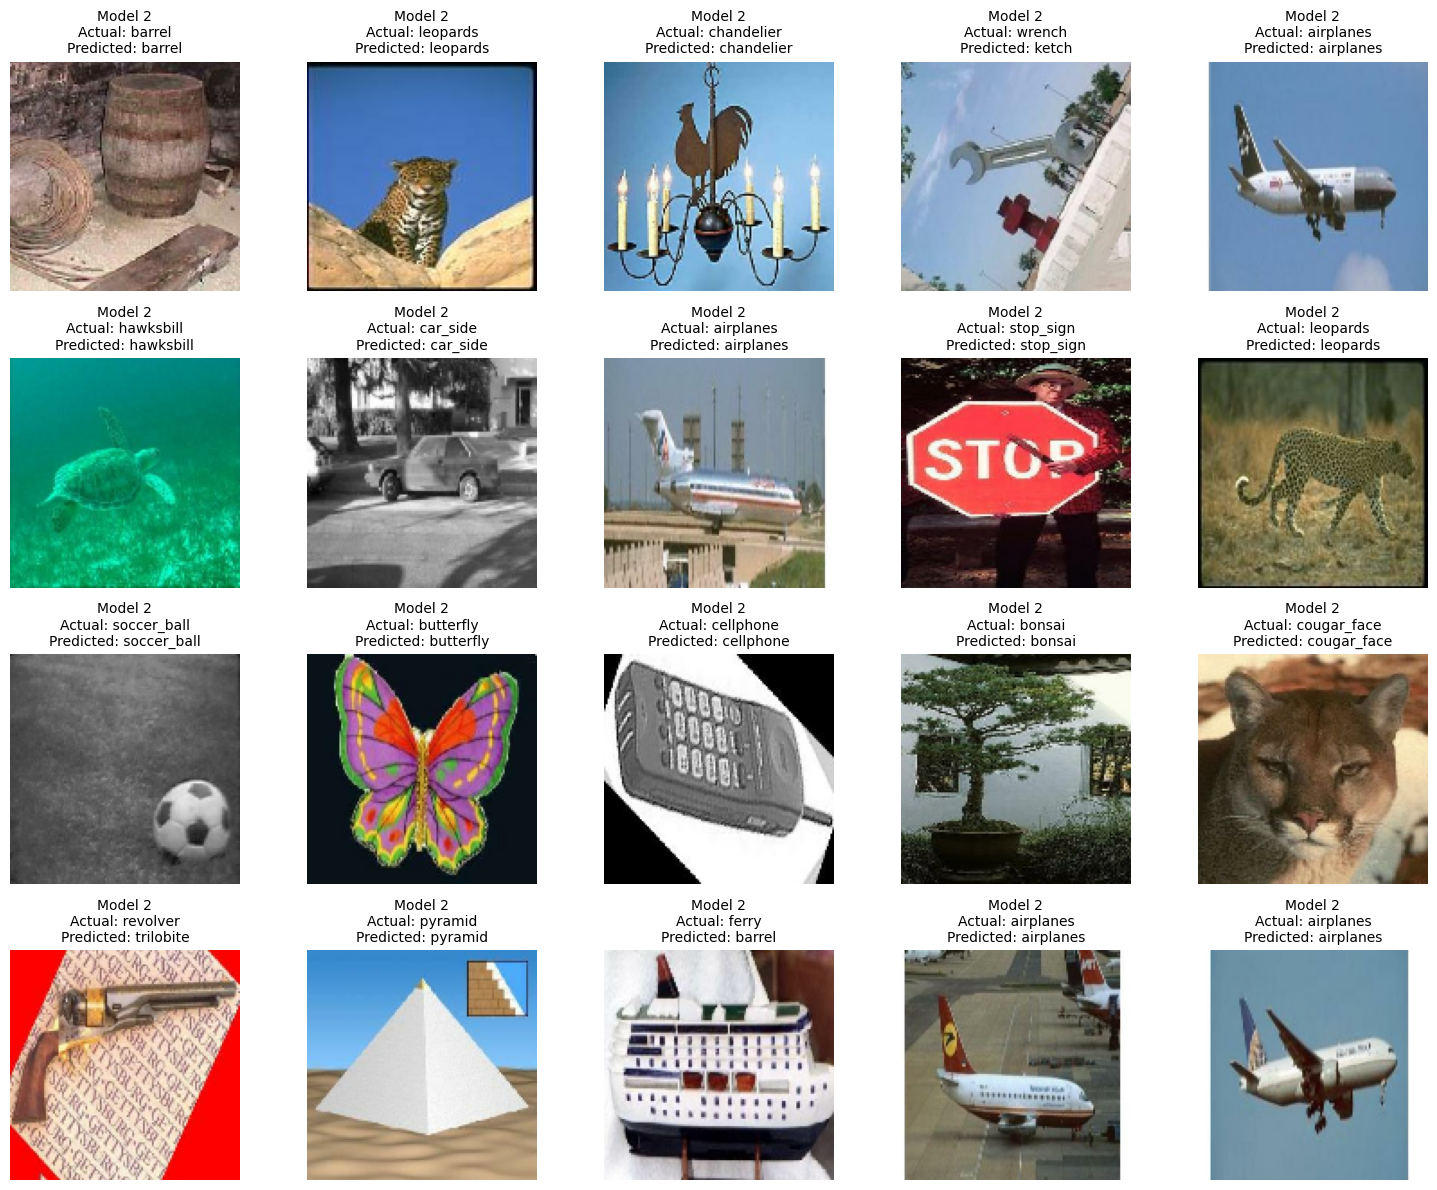

In [133]:
test_models(from_scratch_model, pre_trained_model, 20)